In [8]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle

In [9]:
# Import nyu_depth_v2_labeled.mat file using h5py
f = h5py.File('nyu_depth_v2_labeled.mat', 'r')
f.keys()

<KeysViewHDF5 ['#refs#', '#subsystem#', 'accelData', 'depths', 'images', 'instances', 'labels', 'names', 'namesToIds', 'rawDepthFilenames', 'rawDepths', 'rawRgbFilenames', 'sceneTypes', 'scenes']>

In [10]:
# Extract RGB images, instances, labels
rgb_images = f['images']
instances = f['instances']
labels = f['labels']

In [4]:
# Convert to numpy arrays
rgb_images = np.array(rgb_images)
instances = np.array(instances)
labels = np.array(labels)

In [5]:
# Print shapes of arrays
print(rgb_images.shape)
print(instances.shape)
print(labels.shape)

(1449, 3, 640, 480)
(1449, 640, 480)
(1449, 640, 480)


In [11]:
# Swap second and third dimensions for both instances and labels so it becomes height, width
instances = np.swapaxes(instances, 1, 2)
labels = np.swapaxes(labels, 1, 2)
print(instances.shape)
print(labels.shape)

(1449, 480, 640)
(1449, 480, 640)


In [12]:
# Reshape the image array so that the three colour channels are the last dimension
rgb_images = np.moveaxis(rgb_images, 1, -1)
# swap the second and third dimensions so it becomes height, width, then channels
rgb_images = np.swapaxes(rgb_images, 1, 2)
print(rgb_images.shape)

(1449, 480, 640, 3)


In [13]:
# Pickle the arrays
pickle.dump(rgb_images, open('rgb_images.pkl', 'wb'))
pickle.dump(instances, open('instances.pkl', 'wb'))
pickle.dump(labels, open('labels.pkl', 'wb'))

In [ ]:
# Load the pickled arrays
rgb_images = pickle.load(open('rgb_images.pkl', 'rb'))
instances = pickle.load(open('instances.pkl', 'rb'))
labels = pickle.load(open('labels.pkl', 'rb'))

In [14]:
# Find the type of the arrays
print(rgb_images.dtype)
print(instances.dtype)
print(labels.dtype)

uint8
uint8
uint16


In [15]:
# Print the minimum and maximum values of the arrays
print(np.amin(rgb_images))
print(np.amax(rgb_images))
print(np.amin(instances))
print(np.amax(instances))
print(np.amin(labels))
print(np.amax(labels))

0
255
0
37
0
894


In [16]:
# Convert the images to grayscale
gray_images = np.mean(rgb_images, axis=-1)
print(gray_images.shape)

(1449, 480, 640)


In [17]:
# Convert the images to uint8
gray_images = gray_images.astype(np.uint8)
print(gray_images.dtype)

uint8


In [18]:
# Pickle the grayscale images
pickle.dump(gray_images, open('gray_images.pkl', 'wb'))

In [ ]:
# Load the pickled grayscale images
gray_images = pickle.load(open('gray_images.pkl', 'rb'))

In [19]:
# Print the minimum and maximum values of the arrays
print(np.amin(gray_images))
print(np.amax(gray_images))

0
255


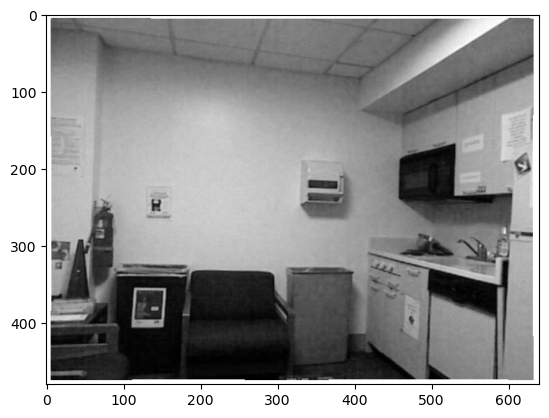

In [20]:
# Plot the first image in grayscale
plt.imshow(gray_images[0], cmap='gray')

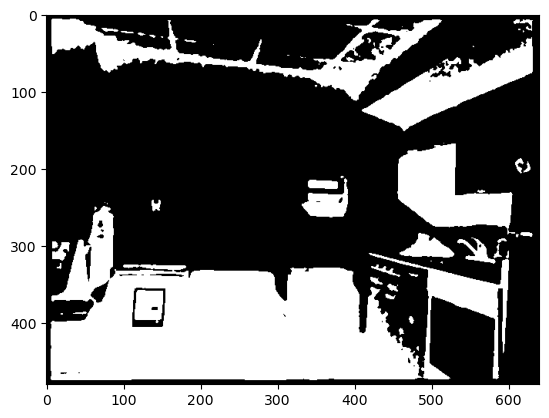

In [21]:
# Perform ostu thresholding on the first image
blurred_image = cv.GaussianBlur(gray_images[0], (5, 5), 0)
_, otsu_image = cv.threshold(
    blurred_image, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
plt.imshow(otsu_image, cmap='gray')

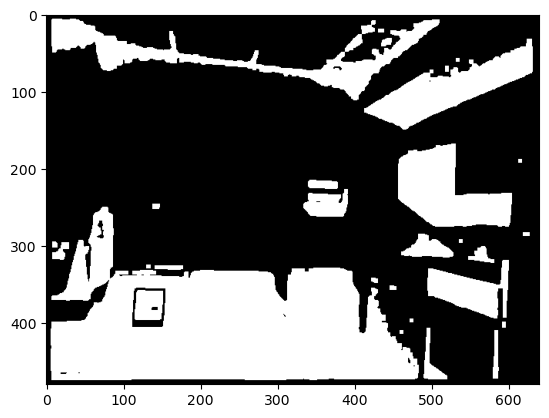

In [22]:
# noise removal
kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
otsu_image = cv.morphologyEx(otsu_image,
                             cv.MORPH_OPEN,
                             kernel,
                             iterations=2)
plt.imshow(otsu_image, cmap='gray')

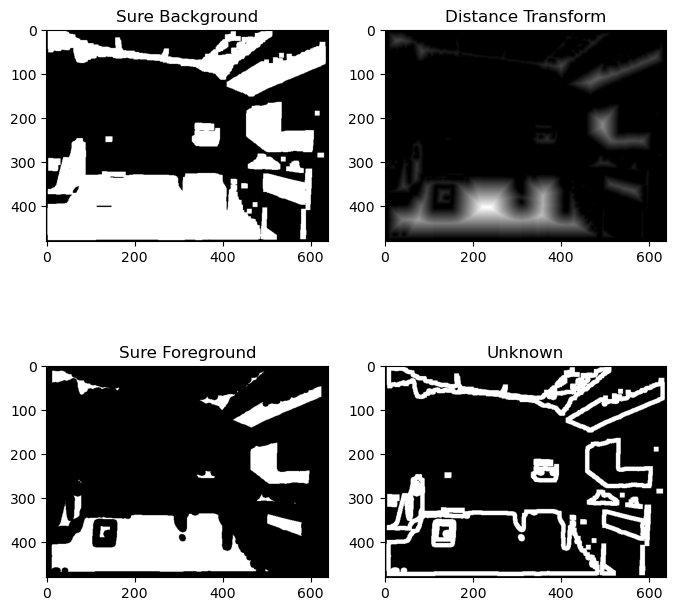

In [23]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# sure background area
sure_bg = cv.dilate(otsu_image, kernel, iterations=3)
# Plot in the top left corner
axes[0, 0].imshow(sure_bg, cmap='gray')
axes[0, 0].set_title('Sure Background')
  
# Distance transform
dist = cv.distanceTransform(otsu_image, cv.DIST_L2, 5)
axes[0, 1].imshow(dist, cmap='gray')
axes[0, 1].set_title('Distance Transform')
  
#foreground area
ret, sure_fg = cv.threshold(dist, 0.1 * dist.max(), 255, cv.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)  
axes[1, 0].imshow(sure_fg, cmap='gray')
axes[1, 0].set_title('Sure Foreground')
  
# unknown area
unknown = cv.subtract(sure_bg, sure_fg)
axes[1, 1].imshow(unknown, cmap='gray')
axes[1, 1].set_title('Unknown')
  
plt.show()

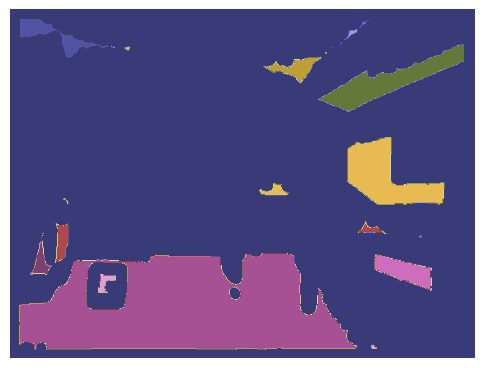

In [24]:
# Marker labelling
# sure foreground 
ret, markers = cv.connectedComponents(sure_fg)
  
# Add one to all labels so that background is not 0, but 1
markers += 1
# mark the region of unknown with zero
markers[unknown == 255] = 0
  
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()

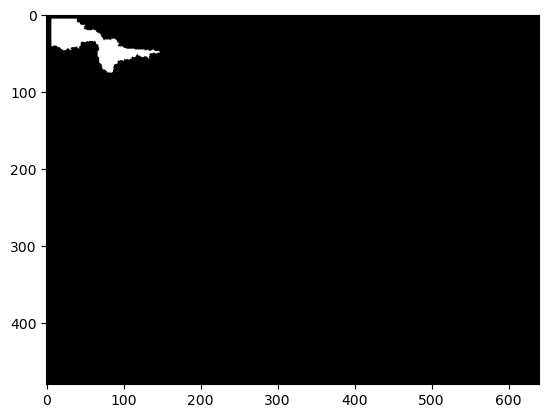

In [27]:
# watershed Algorithm
markers = cv.watershed(rgb_images[0], markers)

labels = np.unique(markers)

# Create a list of binary images in which only the area of the label is in the foreground
# and the rest of the image is in the background

binary_masks = []
for label in labels[2:]:
    # Create a binary image in which only the area of the label is in the foreground
    # and the rest of the image is in the background
    target = np.where(markers == label, 255, 0).astype(np.uint8)
    binary_masks.append(target)

plt.imshow(binary_masks[0], cmap='gray')
plt.show()

In [28]:
image_masks = []

# Apply the otsu thresholding to all images
for i in range(gray_images.shape[0]):
    blurred_image = cv.GaussianBlur(gray_images[i],(5,5),0)
    _, otsu_image = cv.threshold(blurred_image,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    otsu_image = cv.morphologyEx(otsu_image,
                             cv.MORPH_OPEN,
                             kernel,
                             iterations=2)
    
    # sure background area
    sure_bg = cv.dilate(otsu_image, kernel, iterations=3)
    
    # Distance transform
    dist = cv.distanceTransform(otsu_image, cv.DIST_L2, 5)
    
    #foreground area
    ret, sure_fg = cv.threshold(dist, 0.1 * dist.max(), 255, cv.THRESH_BINARY)
    sure_fg = sure_fg.astype(np.uint8)

    # Marker labelling
    # sure foreground 
    ret, markers = cv.connectedComponents(sure_fg)
    
    unknown = cv.subtract(sure_bg, sure_fg)
    
    # Add one to all labels so that background is not 0, but 1
    markers += 1
    # mark the region of unknown with zero
    markers[unknown == 255] = 0
    
    # watershed Algorithm
    markers = cv.watershed(rgb_images[i], markers)

    labels = np.unique(markers)

    # Create a list of binary images in which only the area of the label is in the foreground
    # and the rest of the image is in the background

    binary_masks = []
    for label in labels[2:]:
        # Create a binary image in which only the area of the label is in the foreground
        # and the rest of the image is in the background
        target = np.where(markers == label, 255, 0).astype(np.uint8)
        binary_masks.append(target)
    
    image_masks.append(binary_masks)

In [29]:
# Pickle the image masks
pickle.dump(image_masks, open('image_masks.pkl', 'wb'))